In [1]:
import scraper_eod as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import mibian
import time
import indicator_backtest as i
m = s.StockMongo()

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [ ]:
o = i.Options("FANG")

In [3]:
o.returns.head()

,strike_date,return,rel_risk,probability,volatility,is_won,days_to_strike,iv,iv2,is_lost,vix,date
0,2022-07-15,NaN,NaN,0.408,0.567676,False,NaN,56.7676,56.7676,False,30.959999,2022-05-18
1,2022-07-15,NaN,NaN,0.544,0.567676,False,NaN,56.7676,56.7676,False,30.959999,2022-05-18
2,2022-07-15,-0.385714,0.264151,0.680,0.567676,True,48.0,56.7676,56.7676,True,30.959999,2022-05-18
3,2022-07-15,NaN,NaN,0.816,0.567676,False,NaN,56.7676,56.7676,False,30.959999,2022-05-18
4,2022-07-15,NaN,NaN,0.952,0.567676,False,NaN,56.7676,56.7676,False,30.959999,2022-05-18


In [4]:
r = o.returns.dropna(subset=['rel_risk'])
r = r[(r['rel_risk']>0)&(r['rel_risk']<1)&(r['return']>0)&(r['return']<3)]

<AxesSubplot:xlabel='rel_risk', ylabel='return'>

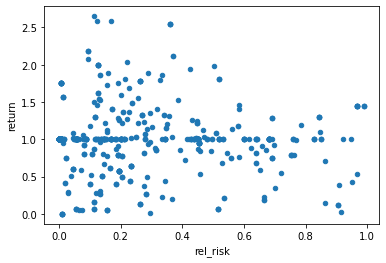

In [5]:
r.plot.scatter(x='rel_risk', y='return')

In [9]:
r.columns.tolist()

['strike_date',
 'return',
 'rel_risk',
 'probability',
 'volatility',
 'is_won',
 'days_to_strike',
 'iv',
 'iv2',
 'is_lost',
 'vix',
 'date']

<AxesSubplot:xlabel='rel_risk', ylabel='iv2'>

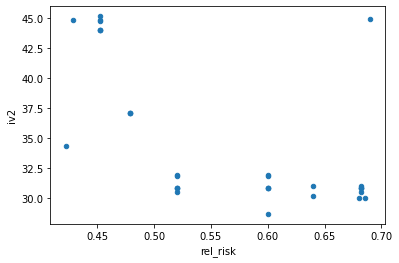

In [33]:
r[(r['rel_risk']>0.4)&(r['probability']>1)&(r['days_to_strike']<50)&(r['days_to_strike']>30)&(r['rel_risk']<0.7)].plot.scatter(x='rel_risk', y='iv2')

In [37]:
m.stock_data.portfolio_time_series.insert_many(r.to_dict('records'))

In [7]:
stats = o.regression()

C:\Users\ander\Documents\yahooScraper\indicator_backtest.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['sqr_rel_risk'] = np.log(selection['rel_risk'])


In [8]:
stats[0]

{'y0': 0.9656133300571765,
 'sqr_rel_risk': 0.04015531209844633,
 'probability': 0.11450871764348311,
 'iv': -0.00013451527020591839,
 'vix': 0.004708308487122814,
 'days_to_strike': -0.0023021267011560237,
 'ticker': 'FANG',
 'date': datetime.datetime(2022, 12, 25, 0, 0)}

In [11]:
from sklearn.linear_model import LinearRegression
self = o
linear_regressor = LinearRegression()
selection = self.returns[(self.returns['rel_risk']>0)&(self.returns['rel_risk']<1)&(self.returns['return']>0)&(self.returns['return']<3)]
selection['sqr_rel_risk'] = np.log(selection['rel_risk'])
y = selection['return']
x = selection[['sqr_rel_risk', 'probability', 'iv', 'vix', 'days_to_strike']]
linear_regressor.fit(x, y)
        

C:\Users\ander\AppData\Local\Temp/ipykernel_22704/1867400287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['sqr_rel_risk'] = np.log(selection['rel_risk'])


LinearRegression()

In [13]:
return_dict = {
            'y0': linear_regressor.intercept_,
            'sqr_rel_risk': linear_regressor.coef_[0],
            'probability': linear_regressor.coef_[1], 
            'iv': linear_regressor.coef_[2], 
            'vix': linear_regressor.coef_[3], 
            'days_to_strike': linear_regressor.coef_[4],
            'ticker': self.ticker,
        }

In [15]:
return_dict

{'y0': 1.1926509280469593,
 'sqr_rel_risk': -0.009333962547497781,
 'probability': -0.07517814696893531,
 'iv': -0.0023567188003906676,
 'vix': -0.0033527506226230753,
 'days_to_strike': 0.0005940722634266565,
 'ticker': 'FANG'}

In [16]:
linear_regressor.score(x, y)

0.0064240679304368165

In [17]:
stats[1].score(x, y)

-0.030875227813921713